# Part 6 Reinforcement Learning

In [1]:
# Importing the dataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Importing the dataset
dataset = pd.read_csv('Ads_CTR_Optimisation.csv')
dataset.head()

,Ad 1,Ad 2,Ad 3,Ad 4,Ad 5,Ad 6,Ad 7,Ad 8,Ad 9,Ad 10
0,1,0,0,0,1,0,0,0,1,0
1,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,1,0,0
4,0,0,0,0,0,0,0,0,0,0


We firstly use random selection algorithm to see the total reward.

In [3]:
# Implementing random selection
import random
N = 10000
d = 10
ads_selected = []
total_reward = 0
for n in range(0, N):
    ad = random.randrange(d)
    ads_selected.append(ad)
    reward = dataset.iloc[n, ad]
    total_reward += reward

total_reward    

1199

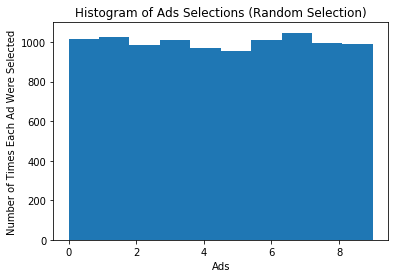

In [4]:
# Visualizing the results
plt.hist(ads_selected)
plt.title('Histogram of Ads Selections (Random Selection)')
plt.xlabel('Ads')
plt.ylabel('Number of Times Each Ad Were Selected')
plt.show()

## 6.1 Upper Confidence Bound (UCB)
### 6.1.1 The Multi-Armed Bandit Problem
- We have $d$ arms. For example, arms are ads that we display to users each time they connect to a web page.
- Each times a user connects to this web page, that makes a round.
- At each round $n$, we choose one ad to display to the user.
- At each round $n$, ad $i$ gives reward $r_i(n)\in\{0,1\}$ if the user clicked on ad $i$, $0$ if the user didn't.
- Our goal is to maximize the total reward we get over many rounds.

### 6.1.2 UCB Intuition
- **STEP 1**: At each round $n$, we consider two numbers for each ad $i$:
    - $N_i(n)$ - the number of times the ad $i$ was selected up to round $n$.
    - $R_i(n)$ - the sum of rewards of the ad $i$ up to round $n$.


- **STEP 2**: From these two numbers we compute:
    - the average reward of ad $i$ up to round $n$:
    
    $$\bar{r}_i(n)=\frac{R_i(n)}{N_i(n)}$$
    
    - the confidence interval $[\bar{r}_i(n)-\Delta_i(n), \bar{r}_i(n)+\Delta_i(n)]$ at around $n$ with
    
    $$\Delta_i(n)=\sqrt{\frac{3}{2}\frac{\log(n)}{N_i(n)}}$$


- **STEP 3**: We select the ad $i$ has the maximum UCB $\bar{r}_i(n)+\Delta_i(n)$.

### 6.1.3 UCB in Python

In [5]:
# Implementing UCB
import math

N = 10000
d = 10
ads_selected = []
numbers_of_selections = [0] * d
sums_of_rewards = [0] * d
total_reward = 0
for n in range(0, N):
    ad = 0
    max_upper_bound = 0
    '''
    This for loop is used to decide which ad will be selected, with the condition that each ad will be selected one 
    by one in the first 10 round.
    '''
    for i in range(0, d):
        if numbers_of_selections[i] > 0:
            average_reward = sums_of_rewards[i] / numbers_of_selections[i]
            delta_i = math.sqrt(3/2 * math.log(n + 1) / numbers_of_selections[i])
            upper_bound = average_reward + delta_i
        else:
            upper_bound = 1e400
        if upper_bound > max_upper_bound:
            max_upper_bound = upper_bound
            ad = i
    ads_selected.append(ad)
    numbers_of_selections[ad] += 1
    reward = dataset.iloc[n, ad]
    sums_of_rewards[ad] += reward
    total_reward += reward

total_reward

2178

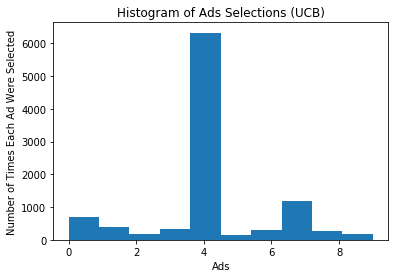

In [6]:
# Visualizing the results
plt.hist(ads_selected)
plt.title('Histogram of Ads Selections (UCB)')
plt.xlabel('Ads')
plt.ylabel('Number of Times Each Ad Were Selected')
plt.show()

## 6.2 Thompson Sampling
### 6.2.1 Thompson Sampling Intuition
- **STEP 1**: At each round $n$, we consider two numbers for each ad $i$:
    - $N_i^1(n)$ - the number of times the ad $i$ got reward $1$ up to round $n$.
    - $N_i^0(n)$ - the number of times the ad $i$ got reward $0$ up to round $n$.
    
    
- **STEP 2**: For each ad $i$, we take an random draw from the distribution below:

$$\theta_i(n)=\beta(N_i^1(n)+1,N_i^0(n)+1)$$

- **STEP 3**: We select the ad that has the highest $\theta_i(n)$.

In Thompson sampling, we build the distributions to guess where we think $\mu^*$ values will be. We are NOT trying to guess the distributions behind the machines.

### 6.2.2 Bayesian Inference
- Ad $i$ gets rewards $y$ from Bernoulli distribution $p(y|\theta_i)\sim B(\theta_i)$.
- $\theta_i$ is unknown but we set its uncertainty by assuming it has a uniform distribution $p(\theta_i)\sim U([0,1]), which is the prior distribution$
- Bayes rules: we approach $\theta_i$ by the posterior distribution:

$$p(\theta_i|y)=\frac{p(y|\theta_i)p(\theta_i)}{\int p(y|\theta_i)p(\theta_i)d\theta_i}\propto p(y|\theta_i)p(\theta_i)$$

where $p(\theta_i|y)$ is the posterior distribution,$p(y|\theta_i)$ is the likelihood function, and $p(\theta_i)$ is the prior distribution.

- We get $p(\theta_i|y)\sim \beta(\text{number of successes}+1,\text{number of failures}+1)$
- At each round $n$ we take a random draw $\theta_i(n)$ from this posterior distribution $p(\theta_i|y)$, for each id $i$.
- At each round $n$ we select ad $i$ that has the highest $\theta_i(n)$.

### 6.2.3 Algorithm Comparison: UCB & Thompson Sampling
- **UCB**:
    - Deterministic
    - Require update at every round
    
    
- **Thompson Sampling**:
    - Probabilistic
    - Can accomodate delayed feedback
    - Better empirical evidence

### 6.2.4 Thompson Sampling in Python

In [7]:
# Implementing Thompson sampling
import random

N = 10000
d = 10
ads_selected = []
numbers_of_rewards_1 = [0] * d
numbers_of_rewards_0 = [0] * d
total_reward = 0
for n in range(0, N):
    ad = 0
    max_random = 0
    for i in range(0, d):
        random_beta = random.betavariate(numbers_of_rewards_1[i] + 1, numbers_of_rewards_0[i] + 1)
        if random_beta > max_random:
            max_random = random_beta
            ad = i
    ads_selected.append(ad)
    reward = dataset.iloc[n, ad]
    if reward == 1:
        numbers_of_rewards_1[ad] += 1
    else:
        numbers_of_rewards_0[ad] += 1
    total_reward += reward

total_reward

2539

Obviously, Thompson sampling beats UCB in this case.

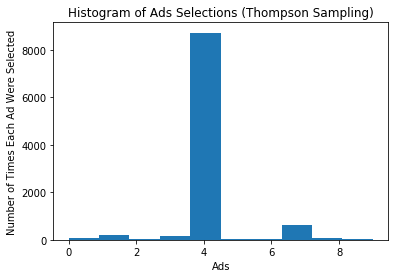

In [8]:
# Visualizing the results
plt.hist(ads_selected)
plt.title('Histogram of Ads Selections (Thompson Sampling)')
plt.xlabel('Ads')
plt.ylabel('Number of Times Each Ad Were Selected')
plt.show()